# COVID-19 Bayesian Real-time estimation of $R_t$

This work is mainly based on [this article][1], and [this blog post][2], 
which again refers to [this notebook][3]. The idea is to iterate equation
13 from the article,

$$P[R|\Delta T(t+1) \leftarrow \Delta T(t)] = \frac{P[\Delta T(t+1) \leftarrow \Delta T(t)|R]\, P[R]}{P[\Delta T(t+1) \leftarrow \Delta T(t)]}\,.$$

The denominator is independent of $R$. The factor $P[R]$ in the numerator
can be substituted for the estimation we get from this equation at the 
previous time step.

[1]: https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0002185#pone.0002185-Bjornstad1
[2]: http://systrom.com/blog/the-metric-we-need-to-manage-covid-19/
[3]: https://github.com/k-sys/covid-19/blob/master/Realtime%20R0.ipynb

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
directory = '/Users/singharu/Desktop/Arulytics/Code/jhu-covid-19/COVID-19/csse_covid_19_data/csse_covid_19_time_series/'

file_name_cases = 'time_series_covid19_confirmed_global.csv'

full_path_cases = directory+file_name_cases

data_cases = pd.read_csv(full_path_cases)

data_cases = data_cases.drop(['Lat','Long'], axis=1)

# now, set the index to reflect country and province

# transpose to get dates as rows make a proper datetime index
df_cases = data_cases.set_index(['Country/Region','Province/State']).transpose()

df_cases = df_cases.set_index(pd.to_datetime(df_cases.index))
df_cases.tail()

Country/Region Afghanistan Albania Algeria Andorra Angola Antigua and Barbuda  \
Province/State         NaN     NaN     NaN     NaN    NaN                 NaN   
2021-05-06           61162  131510  123473   13363  27921                1232   
2021-05-07           61455  131577  123692   13390  28201                1232   
2021-05-08           61755  131666  123900   13406  28477                1232   
2021-05-09           61842  131723  124104   13423  28740                1231   
2021-05-10           62063  131753  124288   13429  28875                1237   

Country/Region Argentina Armenia                    Australia                  \
Province/State       NaN     NaN Australian Capital Territory New South Wales   
2021-05-06       3095582  218325                          124            5521   
2021-05-07       3118134  218681                          124            5527   
2021-05-08       3136158  219092                          124            5533   
2021-05-09       3147740  219270                          124            5538   
2021-05-10       3165121  219353                          124            5542   

Country/Region  ... United Kingdom Uruguay Uzbekistan Vanuatu Venezuela  \
Province/State  ...            NaN     NaN        NaN     NaN       NaN   
2021-05-06      ...        4428553  213449      93176       4    204057   
2021-05-07      ...        4431043  216146      93597       4    205181   
2021-05-08      ...        4433090  218800      93978       4    206549   
2021-05-09      ...        4434860  220683      94397       4    207870   
2021-05-10      ...        4437217  222870      94759       4    209162   

Country/Region Vietnam West Bank and Gaza Yemen Zambia Zimbabwe  
Province/State     NaN                NaN   NaN    NaN      NaN  
2021-05-06        3090             300387  6426  91946    38398  
2021-05-07        3137             300946  6446  92004    38403  
2021-05-08        3245             301437  6462  92057    38414  
2021-05-09        3412             301751  6482  92092    38419  
2021-05-10        3489             302249  6485  92112    38433  

[5 rows x 275 columns]

In [3]:
df_cases.columns.unique()

MultiIndex([(        'Afghanistan',                            nan),
            (            'Albania',                            nan),
            (            'Algeria',                            nan),
            (            'Andorra',                            nan),
            (             'Angola',                            nan),
            ('Antigua and Barbuda',                            nan),
            (          'Argentina',                            nan),
            (            'Armenia',                            nan),
            (          'Australia', 'Australian Capital Territory'),
            (          'Australia',              'New South Wales'),
            ...
            (     'United Kingdom',                            nan),
            (            'Uruguay',                            nan),
            (         'Uzbekistan',                            nan),
            (            'Vanuatu',                            nan),
            (     

In [4]:
country, province = 'India', float('Nan')

In [5]:
de = df_cases[country, province]
de = de[de.index[(de > 50)][0]:]
deltas = (de - de.shift(1)).dropna()

# Raw Counts

Using raw counts won't work in most cases, since the data are so rough the successive
likelihood functions won't have common support.

<AxesSubplot:title={'center':'India'}, ylabel='new cases'>

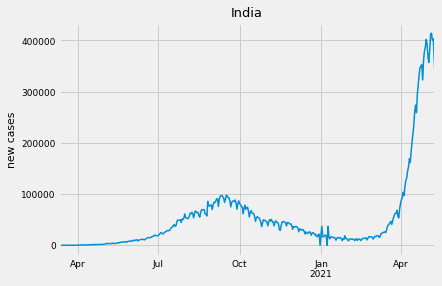

In [6]:
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 9
plt.rcParams['lines.linewidth'] = 1.5
plt.title(country)
plt.ylabel("new cases")
deltas.plot.line()

# Smmothing

We smooth the data using a 7-day Gaussian window.

<AxesSubplot:title={'center':'India'}, ylabel='new cases, smoothed'>

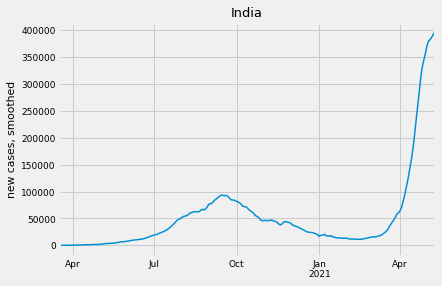

In [7]:
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 9
plt.rcParams['lines.linewidth'] = 1.5
plt.title(country)
plt.ylabel("new cases, smoothed")
k = deltas.rolling(7, win_type='gaussian').mean(std=3).dropna().round()
k.plot.line()

# Likelihood function

As the likelihood function, we use a Poisson distribution. The $\lambda$ parameter
can be estimated from equation 6 of the artilce,

$$\Delta T(t+1) = b(R_t)\Delta T(t)\,$$

with

$$b(R_t) \approx \exp\left\{ \tau \gamma (R_t - 1) \right\}\,.$$

For our data, $\tau = 1$, and $\gamma$ is the inverse of the infectuous period
of around 5.2 days according to [this study][Ganyani]

## TODO

Use uncertainty in $\gamma$.

[Ganyani]: https://www.medrxiv.org/content/10.1101/2020.03.05.20031815v1

In [8]:
tau = 1

In [9]:
import scipy

In [10]:
r_range = np.linspace(0, 10, 500)

In [11]:
Tc = 5.2 #Median Infectious Period
gamma = 1/Tc #Inverse of Infectious Period
lambdas = np.outer(k[:-1],  np.exp(tau*gamma*(r_range - 1))) #Both equations governing the dynamic of infection

In [12]:
import scipy.stats

In [13]:
L = scipy.stats.poisson.pmf(k[1:], lambdas.T) #Assuming Poisson Distribution

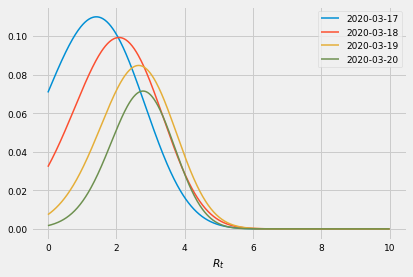

In [14]:
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 9
plt.rcParams['lines.linewidth'] = 1.5
for i in range(4):
    plt.plot(r_range, L[:,i], label=k.index[i].date())
plt.xlabel("$R_t$")
plt.legend()

# Iterative Bayesian Updates

Now we update our estimate. We choose a window function instead of going back through the whole time series since a strong prior > 1 will prevent us from dipping under 1 at all.

In [15]:
P  = L.copy()
W = 2
for i in range(L.shape[1]):
    P[:,i] = L[:,i] / L[:,i].sum()
    for j in range(1, min(W, i)):
        P[:,i] *= L[:,i-j]
        P[:,i] /= P[:,i].sum()

# Estimate confidence intervals

In [16]:
lower = [r_range[np.argwhere(P[:,i].cumsum() >= 0.025)[0]][0] for i in range(len(k) - 1)]
middle = [r_range[np.argwhere(P[:,i].cumsum() >= 0.5)[0]][0] for i in range(len(k) - 1)]
upper = [r_range[np.argwhere(P[:,i].cumsum() >= 0.975)[0]][0] for i in range(len(k) - 1)]

Text(0.5, 1.0, 'India')

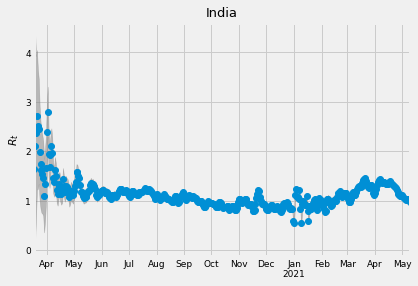

In [17]:
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 9
plt.rcParams['lines.linewidth'] = 1.5
plt.ylabel('$R_t$')
pd.Series(middle, index=k.index[1:]).plot.line(lw=0, marker="o")
plt.fill_between(k.index[1:], lower, upper, color='grey', alpha=0.5)
plt.title(country)
#plt.savefig('R_tNorway.png', dpi=300)

In [18]:
middle_us = pd.Series(middle)
lower_us = pd.Series(lower)
upper_us = pd.Series(upper)

frames = [middle_us, lower_us, upper_us]
all_data_unsmoothed = pd.concat(frames, sort = False, axis=1)
all_data_unsmoothed.columns = ['Middle_Unsmoothed','Lower_Unsmoothed','Upper_Unsmoothed']
all_data_unsmoothed.index=k.index[1:]
all_data_unsmoothed.tail()

,Middle_Unsmoothed,Lower_Unsmoothed,Upper_Unsmoothed
2021-05-06,1.042084,1.022044,1.042084
2021-05-07,1.042084,1.022044,1.042084
2021-05-08,1.042084,1.042084,1.042084
2021-05-09,1.042084,1.042084,1.042084
2021-05-10,0.981964,0.981964,1.002004


In [19]:
middle_7d_ma = pd.Series(middle).rolling(7).mean()
lower_7d_ma = pd.Series(lower).rolling(7).mean()
upper_7d_ma = pd.Series(upper).rolling(7).mean()

frames = [middle_7d_ma, lower_7d_ma, upper_7d_ma]
all_data = pd.concat(frames, sort = False, axis=1)
all_data.columns = ['Middle','Lower','Upper']
all_data.index=k.index[1:]
all_data.tail()

,Middle,Lower,Upper
2021-05-06,1.067850,1.059261,1.073576
2021-05-07,1.059261,1.047810,1.062124
2021-05-08,1.047810,1.039221,1.050673
2021-05-09,1.042084,1.033496,1.042084
2021-05-10,1.030633,1.022044,1.033496


Text(0.5, 1.0, "India's R-Number Over Time (7-Day Moving Average)")

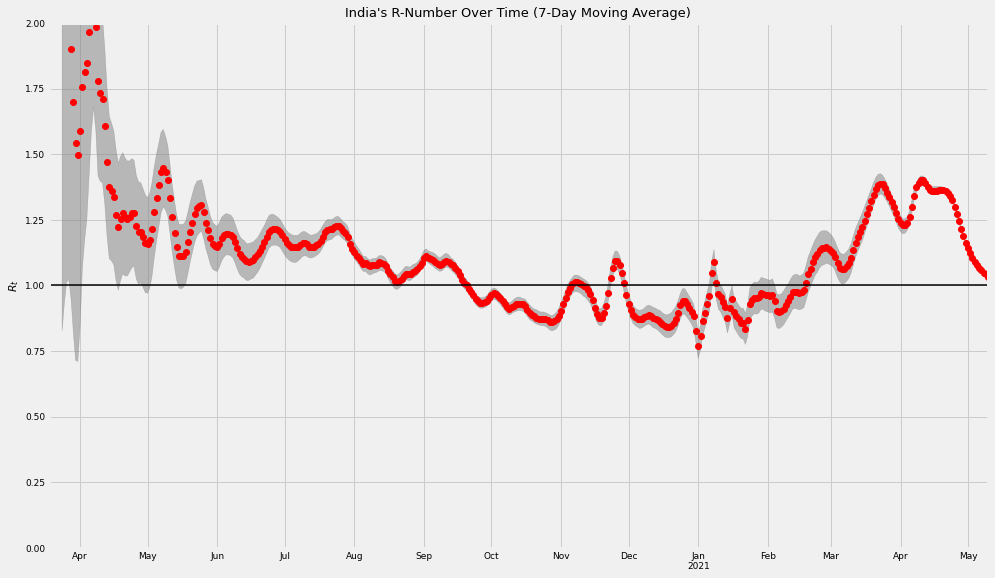

In [20]:
fig, ax1 = plt.subplots()

plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 9
plt.rcParams['lines.linewidth'] = 1.5
all_data['Middle'].plot.line(lw=0, marker="o",figsize=(15, 9), color = 'red')
plt.fill_between(k.index[1:], all_data['Lower'], all_data['Upper'], color='grey', alpha=0.5)
ax1.set_ylim(0, 2)
plt.ylabel('$R_t$')
plt.axhline(y=1, color = 'black')
plt.title(country + "'s R-Number Over Time (7-Day Moving Average)")
#plt.savefig('R_tNorway.png', dpi=300)

# All-in-one function

In [21]:
#country = 'Spain'
def estimate_R(country):
    de = df_cases[country, float('nan')]
    de = de[de.index[(de > 30)][0]:]
    deltas = (de - de.shift(1)).dropna()
    k = deltas.rolling(4, win_type='gaussian').mean(std=3).dropna().round()
    tau = 1
    r_range = np.linspace(0, 10, 500)
    Tc = 5.2
    gamma = 1/Tc
    lambdas = np.outer(k[:-1],  np.exp(tau*gamma*(r_range - 1)))
    L = scipy.stats.poisson.pmf(k[1:], lambdas.T)
    P  = L.copy()
    W = 7
    for i in range(L.shape[1]):
        P[:,i] = L[:,i] / L[:,i].sum()
        for j in range(1, min(W, i)):
            P[:,i] *= L[:,i-j]
            P[:,i] /= P[:,i].sum()
    lower = [r_range[np.argwhere(P[:,i].cumsum() >= 0.025)[0]][0] for i in range(len(k) - 1)]
    middle = [r_range[np.argwhere(P[:,i].cumsum() >= 0.5)[0]][0] for i in range(len(k) - 1)]
    upper = [r_range[np.argwhere(P[:,i].cumsum() >= 0.975)[0]][0] for i in range(len(k) - 1)]
    return pd.DataFrame({'median': middle, 'lower': lower, 'upper': upper}, index=k.index[1:])

In [22]:
def plot_country(country_to_estimate):
    estimates = estimate_R(country_to_estimate)
    estimates['median'].plot.line(marker='o', lw=0)
    plt.fill_between(estimates.index, estimates['lower'], estimates['upper'], alpha=0.6, color='grey')
    plt.title(country_to_estimate)

In [23]:
#r0_germany = estimate_R('Germany')['median']
r0_norway = estimate_R('Norway')['median']
#r0_denmark = estimate_R('Denmark')['median']
r0_italy = estimate_R('Italy')['median']
#r0_sweden = estimate_R('Sweden')['median']
#r0_india = estimate_R('India')['median']
r0_korea = estimate_R('Korea, South')['median']
#r0_switzerland = estimate_R('Switzerland')['median']

In [24]:
'''
frames = [r0_germany, r0_norway, r0_denmark, r0_italy,
          r0_sweden, r0_india, r0_korea, r0_switzerland]
final_data = pd.concat(frames, sort = False, axis=1)
final_data.columns = ['Germany','Norway','Denmark','Italy',
                      'Sweden','India','South Korea','Switzerland']
final_data.tail(14)

'''
frames = [r0_norway, r0_italy, r0_korea]
final_data = pd.concat(frames, sort = False, axis=1)
final_data.columns = ['Norway','Italy',
                      'South Korea']
final_data.tail(14)


,Norway,Italy,South Korea
2021-04-27,1.002004,0.961924,0.981964
2021-04-28,0.921844,0.961924,0.981964
2021-04-29,0.941884,0.941884,0.941884
2021-04-30,0.901804,0.921844,0.901804
2021-05-01,0.801603,0.941884,0.881764
2021-05-02,0.921844,0.881764,0.901804
2021-05-03,0.921844,0.861723,0.941884
2021-05-04,0.921844,0.861723,0.961924
2021-05-05,0.941884,0.821643,0.941884
2021-05-06,1.002004,0.841683,0.901804


In [25]:
final_data_r0_ma = final_data.rolling(14).mean()
#final_data_r0_ma.plot.line()

In [26]:
final_data_r0_ma.tail(15)

,Norway,Italy,South Korea
2021-04-26,0.828800,0.960492,1.034927
2021-04-27,0.835958,0.959061,1.026338
2021-04-28,0.837389,0.951904,1.020613
2021-04-29,0.847409,0.940452,1.013455
2021-04-30,0.861723,0.930432,1.006298
2021-05-01,0.863155,0.929001,0.997710
2021-05-02,0.871743,0.927569,0.990553
2021-05-03,0.877469,0.926138,0.986258
2021-05-04,0.888921,0.923275,0.983395
2021-05-05,0.901804,0.917549,0.979101


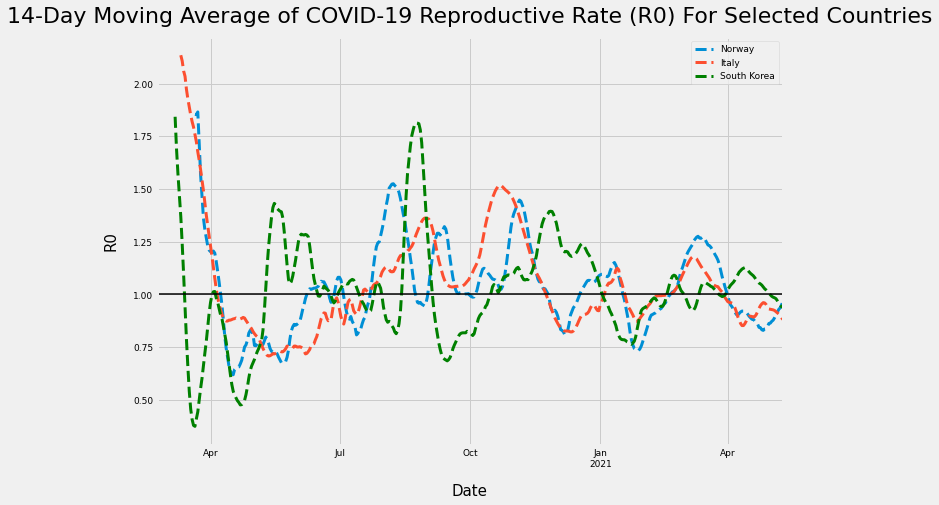

In [27]:
#import seaborn as sns

#number_of_plots = 8

ax1 = plt.subplots()
#colors = sns.color_palette("Set2", 8)
#sns.palplot(colors)

#colormap = plt.cm.nipy_spectral
#colors = [colormap(i) for i in np.linspace(0, 1,number_of_plots)]
#ax.set_prop_cycle('color', colors)

# multiple line plot
#final_data_r0_ma['Germany'].plot(figsize=(10, 7), linewidth=3, style='--', legend = True)
final_data_r0_ma['Norway'].plot(figsize=(10, 7), linewidth=3, style='--', legend = True)
#final_data_r0_ma['Denmark'].plot(figsize=(10, 7), linewidth=3, style='--', legend = True)
final_data_r0_ma['Italy'].plot(figsize=(10, 7), linewidth=3, style='--', legend = True)
#final_data_r0_ma['Sweden'].plot(figsize=(10, 7), linewidth=3, style='--', legend = True)
#final_data_r0_ma['India'].plot(figsize=(10, 7), linewidth=3, style='--', legend = True, color = 'indigo')
final_data_r0_ma['South Korea'].plot(figsize=(10, 7), linewidth=3, style='--', legend = True, color = 'green')
#final_data_r0_ma['Switzerland'].plot(figsize=(10, 7), linewidth=3, style='--', legend = True, color = 'pink')
plt.axhline(y=1, color = 'black')
#plt.set_ylim(0, 2.5)
# Add titles
plt.xlabel("Date", labelpad=15, fontsize = 15, color = 'black')
plt.ylabel("R0", labelpad=15, fontsize = 15, color = 'black')
plt.title("14-Day Moving Average of COVID-19 Reproductive Rate (R0) For Selected Countries", y=1.02, fontsize=22, color = 'black');

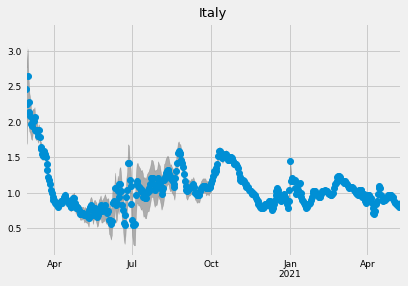

In [28]:
plot_country('Italy')

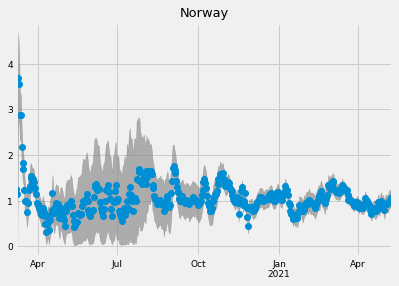

In [29]:
plot_country("Norway")

In [30]:
#plot_country('Spain')

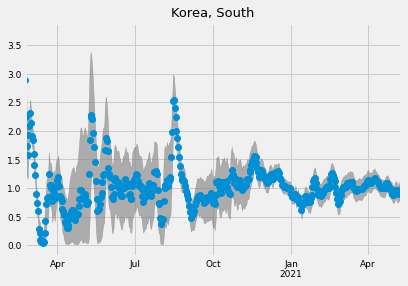

In [31]:
plot_country('Korea, South')

In [32]:
#plot_country('India')

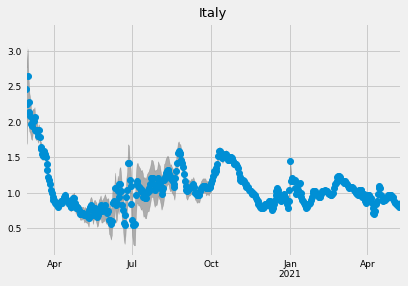

In [33]:
plot_country('Italy')

In [38]:
#plot_country('Sweden')

In [35]:
#plot_country('Germany')

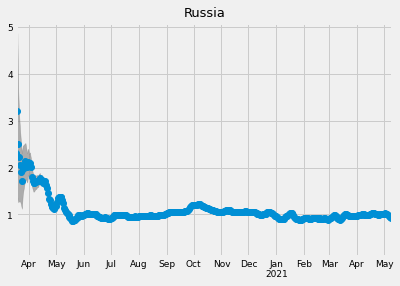

In [36]:
plot_country('Russia')